In [ ]:
!pip install easyocr pytesseract transformers pillow torch torchvision

In [ ]:
!rm /opt/conda/lib/libcurl.so.4 
!ln -s /usr/lib/x86_64-linux-gnu/libcurl.so.4.8.0 /opt/conda/lib/libcurl.so.4
!add-apt-repository ppa:alex-p/tesseract-ocr5 -y
!apt update
!apt install -y tesseract-ocr
!apt install tesseract-ocr-eng
# If you want all languages -- please note this will take time to download. You could also point to the already install tessdata in 4.00 as well.
# !apt install tesseract-ocr-all -y
!tesseract --version

In [ ]:
!pip install Levenshtein

In [32]:
import json
import os
import re
from PIL import Image
import easyocr
import pytesseract
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import torch
from concurrent.futures import ThreadPoolExecutor
from difflib import SequenceMatcher
import logging
import numpy as np
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from Levenshtein import distance as levenshtein_distance

print(pytesseract.get_tesseract_version())
print(pytesseract.get_languages())

5.4.1
['eng']


In [ ]:
# Paths
input_dir = "/selected_images"
output_file = "ocr_results.json"

# Check for GPU availability
device = 'cuda' if torch.cuda.is_available() else 'cpu'
logging.info(f"Using device: {device}")

# Initialize OCR tools
easyocr_reader = easyocr.Reader(['en'], gpu=torch.cuda.is_available())  # Enable GPU for EasyOCR if available
#pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'  # Update this path to your Tesseract installation
trocr_processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-handwritten')
trocr_model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-handwritten').to(device)  # Move TrOCR model to GPU if available


In [34]:
# Set up logging
logging.basicConfig(filename='ocr_processing.log', level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')

In [35]:
def preprocess_image(image_path):
    # Load image using OpenCV
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Apply Gaussian blur to smooth edges
    image = cv2.GaussianBlur(image, (5, 5), 0)

    # Apply adaptive thresholding to binarize the image
    image = cv2.adaptiveThreshold(
        image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY, 7, 2
    )

    # Dilate to close gaps in text
    kernel = np.ones((3,3), np.uint8)
    image = cv2.dilate(image, kernel, iterations=1)

    # Resize the image to enhance readability
    #image = cv2.resize(image, (0,0), fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
    fig = plt.figure(figsize= [10,10])
    plt.imshow(image,cmap='gray', vmin=0, vmax=255)
    return image

In [36]:
# Helper function for TrOCR
def trocr_ocr(image_path):
    try:
        img = cv2.imread(image_path)
        pixel_values = trocr_processor(img, return_tensors="pt").pixel_values.to(device)  # Move input tensor to GPU if available
        generated_ids = trocr_model.generate(pixel_values)
        text_trocr = trocr_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        return text_trocr
    except Exception as e:
        logging.error(f"TrOCR failed for {image_path}: {e}")
        print(f"TrOCR failed for {image_path}: {e}")
        return ""

In [37]:
# Helper function for Easy OCR
def easyocr_ocr(image_path):
    try:
        img = cv2.imread(image_path)
        return " ".join(easyocr_reader.readtext(img, detail=0))
    except Exception as e:
        logging.error(f"EasyOCR failed for {image_path}: {e}")
        return ""

In [38]:
# Helper function for Tesseract
def pytesseract_ocr(image_path):
    try:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        text_pytesseract = pytesseract.image_to_string(img)
        # Tesseract is not very good in recognizing big thick letters and gives back empty string.
        # Let's tackle such cases with image pre-processing
        if text_pytesseract == "":
            #preprocessed_image = preprocess_image(image_path)
            text_pytesseract = pytesseract.image_to_string(preprocess_image(image_path))
        return text_pytesseract
    except Exception as e:
        print(f"PyTesseract failed for {image_path}: {e}")
        logging.error(f"PyTesseract failed for {image_path}: {e}")
        return ""

In [39]:
# Function to compute the Levenshtein distance between strings
def similarity(a, b):
    return 1 - levenshtein_distance(a, b) / max(len(a), len(b))

# Function to apply majority voting and contextual analysis
def majority_vote(texts):
    if not texts:
        return ""

    # Tokenize each text into words and align lengths
    tokenized_texts = [text.split() for text in texts]
    max_len = max(len(tokens) for tokens in tokenized_texts)
    aligned_texts = [tokens + [''] * (max_len - len(tokens)) for tokens in tokenized_texts]

    # Combine tokens at each position using majority vote
    consensus_tokens = []
    for i in range(max_len):
        tokens_at_i = [tokens[i] for tokens in aligned_texts if tokens[i]]
        most_common_token = Counter(tokens_at_i).most_common(1)[0][0]
        consensus_tokens.append(most_common_token)

    return ' '.join(consensus_tokens).strip()

# Function to select the best OCR output
def select_best_text(texts):
    if not texts:
        return ""
    
    # Use Levenshtein distance to find the most consistent text
    best_text = max(texts, key=lambda text: sum(similarity(text, other) for other in texts if text != other))
    
    # Use majority vote as an additional check
    majority_text = majority_vote(texts)
    
    # If the best text and majority text are similar, return one of them
    if similarity(best_text, majority_text) > 0.9:
        return best_text
    
    # If there's a significant difference, log and choose the one with higher consensus
    logging.warning(f"Discrepancy found between best and majority texts: {best_text} vs {majority_text}")
    return best_text if similarity(best_text, majority_text) >= 0.5 else majority_text

In [40]:
# OCR processing function
def process_image(image_name):
    image_path = os.path.join(input_dir, image_name)
    if image_name.endswith('.jpg') or image_name.endswith('.png'):
        text_easyocr = easyocr_ocr(image_path)
        text_pytesseract = pytesseract_ocr(image_path)
        text_trocr = trocr_ocr(image_path)

        # Store raw texts
        raw_texts = [text_pytesseract,text_easyocr, text_trocr]
        print(raw_texts)
        
        # Determine consensus text using similarity comparison
        if any(raw_texts):
            #best_text = max(raw_texts, key=lambda t: sum(similar(t, other) for other in raw_texts if t != other))
            best_text = select_best_text(raw_texts)
        else:
            best_text = ""

        # Log the selected text
        logging.info(f"Processed {image_name} with consensus text: {best_text}")
        
        return {
            "image_name": image_name,
            "text": best_text
        }
    else:
        logging.warning(f"Unsupported file format: {image_name}")
        return {
            "image_name": image_name,
            "text": ""
        }

In [41]:
# Main execution with ThreadPoolExecutor for performance
def main():
    results = []
    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(process_image, image_name) for image_name in os.listdir(input_dir)]
        for future in futures:
            result = future.result()
            if result:
                results.append(result)

    # Validate and sanitize JSON output
    for result in results:
        result["text"] = result["text"].strip()  # Trim leading/trailing whitespace
        print(result)
    
    # Save to JSON
    with open(output_file, 'w') as f:
        json.dump(results, f, indent=4)

    logging.info(f"Results saved to {output_file}")

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['Investment , Sudan\n', 'Investment Sudan', 'Investment, Sudan']


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['Knowledge in video editing.\n', 'Knowledge in video editing:', 'Knowledge in video editing.']


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['Social Media Marketing\n', 'Social Medij Marketing', 'Social Media Marketing']
['EDUCATION\n', 'EDUCATION', 'education']


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['HONOURS/AWARDS\n', 'HONOURSIAWARDS', 'Honours, awards']


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['My Contact\n', 'My Contact', 'My Contact']


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['', 'CONTACT', 'contact']


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['and procedures.\n', 'and procedures_', 'and procedures.']
['Backend : Golang\n', 'Backend : Golang', 'Backend : Golang']


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['consistency.\n', 'consistency_', 'consistency.']
['departments to maintain operational activities.\n', 'departments to maintain operational activities_', 'departments to maintain operational activities.']
['Microservice Development © Open Source Contributions\n', 'Microservice Development Open Source Contributions', 'Microservice Development 2000 - Open Source Contributions']


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['', 'Contact', 'contact']
['PROFESSIONAL DEVELOPMENT\n', 'PROFESSIONAL DEVELOPMENT', 'Professional development']


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['', '1982', '1 982']
['', 'EY', 'ey']


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['(2012)\n', '(2012)', '( 2/2 )']


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['strategies.\n', 'strategies:', 'strategies.']
['Master of Technology (Information Systems) CGPA: 8.7\n', 'Master of Technology (Information Systems) CGPA : 8.7', 'Master of Technology ( Information Systems ) CGPA : 8.7']


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['Last Year Grade : Good\n', 'Last Year Grade Good ( :', 'Last Year Grade 1 : Good']


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['license, tenancy contracts etc.\n', 'license, tenancy contracts etc:', 'license, tenancy contracts etc.']


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['Authority Matrix.\n', 'Authority Matrix:', 'Authority Matrix.']


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['', 'SKILLS:', 'skills :']


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['Manager, Human Resources\n', 'Manager_Human Resources', 'Manager, Human Resources']
['Made html, css adding javascript and Jquery.\n', 'Made html, css adding javascript and Jquery.', 'Made html, css adding javascript and I query.']
['Marital status :Unmarried\n', 'Marital status Unmarried', 'Martial status. " Unmarried']


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['Layout design.\n', 'Layout design:', 'Layout design.']
['Dec, 2018 - Jan, 2020\n', 'Dec; 2018 Jan; 2020', 'Dec. 2018 - Jan. 2020']


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['or expiry.\n', 'or expiry:', 'or expiry.']


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['EXPERTISE\n', 'EXPERTIS E', 'E X P.E R.T.I.E.']


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['Driving License: UAE | UK\n', 'Driving License: UAE UK', 'Driving License. UAE, UK']
['06/2013 - 09/2014\n', '06/2013 09/2014', '0612013-0912014']


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['assigned to me from time to time.\n', 'assigned to me from time to time_', 'assigned to me from time to time.']


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['Project Manager / Solution Architect\n', 'Project Manager Solution Architect', 'Project Manager ) Solution Architect']


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['', 'EDUCATION', 'education']


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['University of Karachi\n', 'University 0f Karachi', 'University of Karachi']


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['Page 30f 4\n', 'Page 3 of 4', 'Page 3 of 4']


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['Degree / Examination {| University /Board\n\n', 'Degree Examination University /Board', 'Degree! Examination. " University Board']


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['Address- Barsha Heights- Dubai, UAE\n', 'Address- Barsha Heights- Dubai; UAE', 'Address-Barsha Heights-Dubai, UAE']


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['Marketing, Sales\n', 'Marketing; Sales', 'Marketing sales']


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['Languages)\n', 'Languages', 'Languages']


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['LINKEDIN\n', 'LINKEDIN', 'linked in']
['ORACLE FINANCIAL SERVICES SOFTWARE LTD, MUMBAI, INDIA\n', 'ORACLE FINANCIAL SERVICES SOFTWARE LTD, MUMBAI; INDIA', 'Oracle Financial Services Software Ltd, Mumbai, India']


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['departments.\n', 'departments', 'departments.']


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['Implementation and renewal of various insurance and\n', 'mplementation and renewal of various insurance and', 'Implementation and renewal of various insurance and']


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['B.Sc. Business Management (Special), CIMA-UK (Reading)\n', 'B.Sc: Business Management (Special), CIMA-UK (Reading)', 'also business Management ( Special, DIMA-UK Reading )']


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['SN\nHardware/Seftware.\n', 'Hardware/Software', 'Hardware, Software']


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['Modules).\n', 'Modules)', 'modules ).']


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['required by the management.\n', 'required by the management', 'required by the management.']


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['Manager — Industrial loT & Analytics\n', 'Manager _ Industrial loT & Analytics', 'Manager - Industrial to T.8x Analytics']
['in sales.\n', 'in sales_', 'in sales.']


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['Arabic : Native Language.\n', 'Arabic Native Language.', 'trophic : Native Language.']


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['Egypt, Cairo\n', 'Egypt; Cairo', 'Egypt, Cairo']


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['necessary action.\n', 'necessary action', 'necessary action.']
['market fit.\n', 'market fit', 'market fit.']


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['quarterly basis.\n', 'quarterly basis:', 'quarterly basis.']


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['AFA (UK), MIPA (AUS), MAAT (SL), CIMA (UK)\n', 'AFA (UK), MIPA (AUS)_ MAAT (SL), CIMA (UK)', 'AFA CUK ), MIPA CAUS ), MAAT ( SL ),']


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['Short Term Courses in:\n', 'Short Term Courses in :', 'Short Term Courses in?']


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['EDUCATION DEGREE/CERTIFICATION\n', 'EDUCATION DEGREEICERTIFICATION', 'education degree, certification']


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['Achievements/Tasks\n', 'Achievements/ Tasks', 'Achievements ( Tasks']
['Graduation Year : VAi02005\n', 'Graduation Year :110005', 'Graduation Year : 1,005']


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['CIMA - Chartered Institute of\n', 'CIMA Chartered Institute of', 'CIMA - Chartered Institute of']


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['Huawei Product promotions.\n', 'Huawei Product promotions', 'Huawei Product promotions.']


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['Page2|2\n', 'Pa g e 2 | 2', 'page 2 ) 2']


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['study information.\n', 'study information', 'study information.']
["EDUCATION HISTORY making sure it's to clients specification.\n", "EDUCATION HISTORY making sure it's to clients specification:", "EDUCATION HISTORY asking sure it's to clients specification."]


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['Python, Power BI, and Tableau technologies.\n', 'Python, Power Bl, and Tableau technologies', 'Python, Power B ), and Tableau technologies.']
['Maintained high level of contact with all vendors.\n', 'Maintained high level of contact with all vendors', 'Maintained high level of contact with all vendors.']


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['accounts payable.\n', 'accounts payable:', 'accounts payable.']
['region.\n', 'region_', 'region.']
['. ee a! A\nPowerPoint - Access\n', 'PowerPoint Access', 'PowerPoint-Access']
["Height : 5'3”\n", 'Height 5\'3"', 'Height, "']
['Senior Associate - STAT & GAAP Audit\n', 'Senior Associate STAT & GAAP Audit', 'Senior Associate - STAT & GAAP Audit']
['Accounts P/R, Budget Management,\n', 'Accounts PIR, Budget Management;', 'Accounts P.R. Budget Management']
['Used web-based document sharing tools.\n', 'Used web-based document sharing tools_', 'Used web-based document sharing tools.']
{'image_name': '001aed822d7ac999bf36e50069086c2c525c1902_page_1_22.jpg', 'text': 'EDUCATION'}
{'image_name': '0012dee5e2feda28d4f81b3f5ae3d6c7dc62a415_page_4_22.jpg', 'text': 'Knowledge in video editing.'}
{'image_name': '004d20c0c4462de2cffdbc9720abb62da1bd9a5c_page_1_24.jpg', 'text': 'Social Media Marketing'}
{'image_name': '003a6e467df4ad0413d49a8fa15d3d16e47cb000_page_2_31.jpg', 'text': 'departments to 

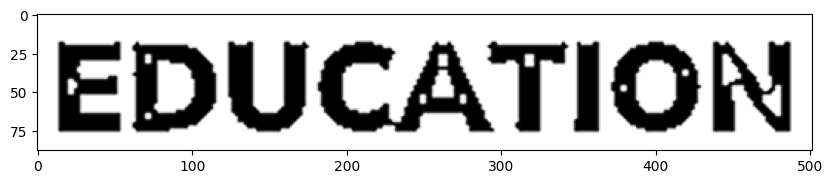

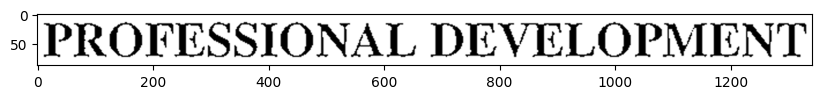

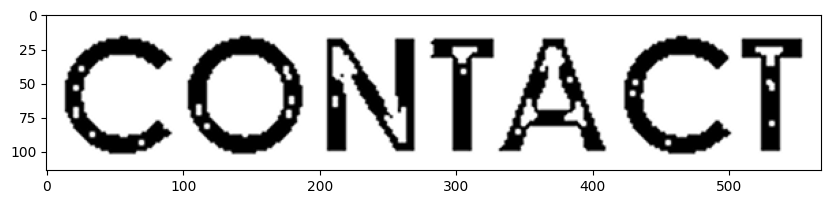

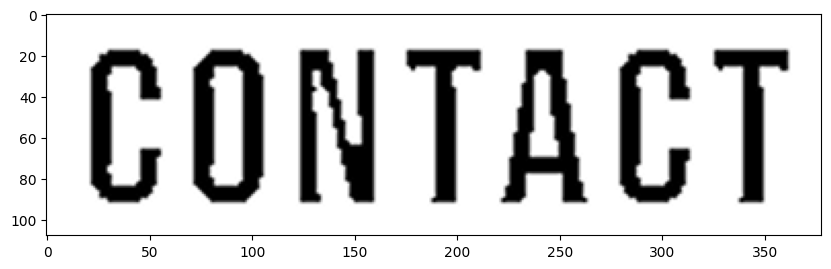

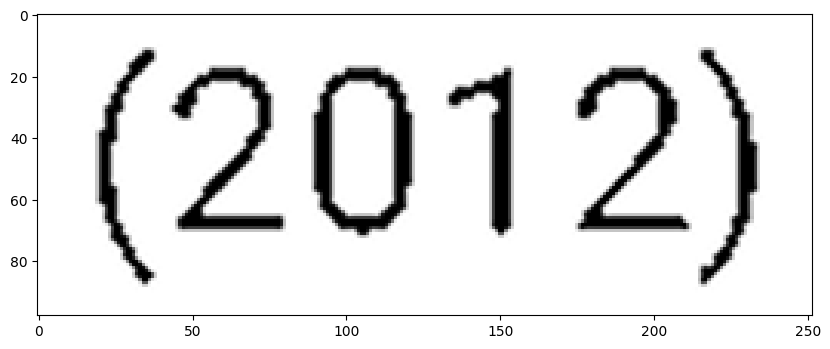

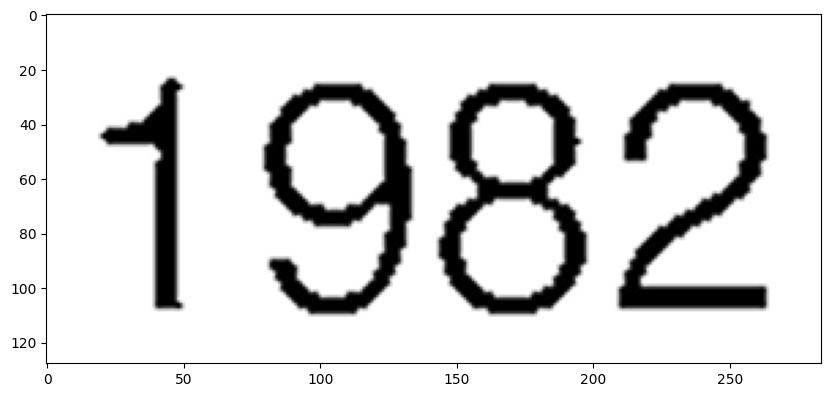

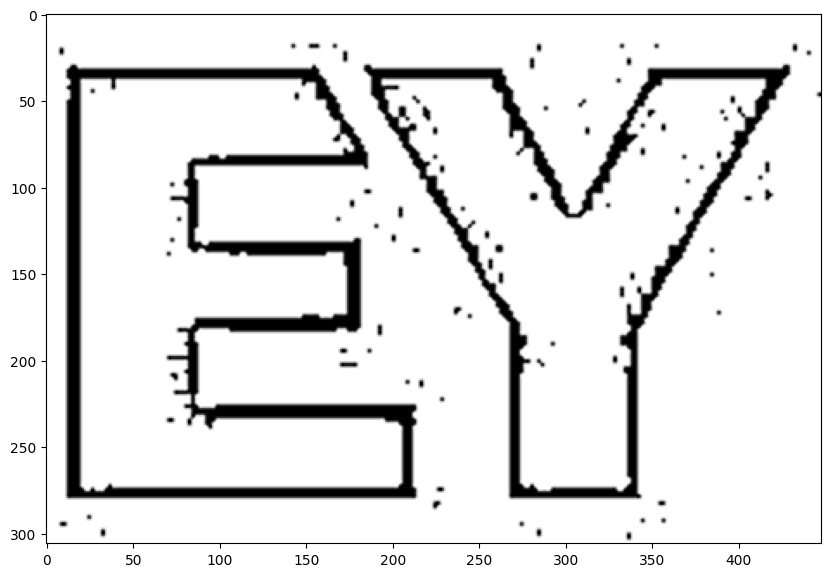

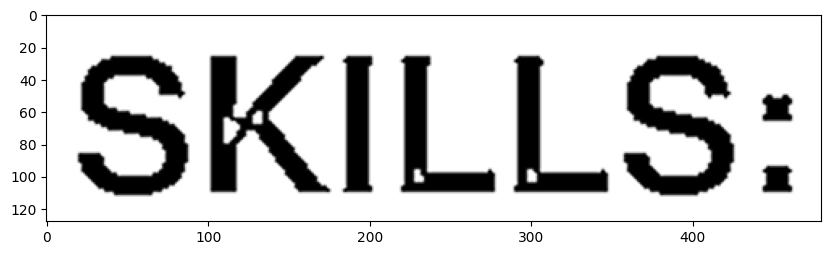

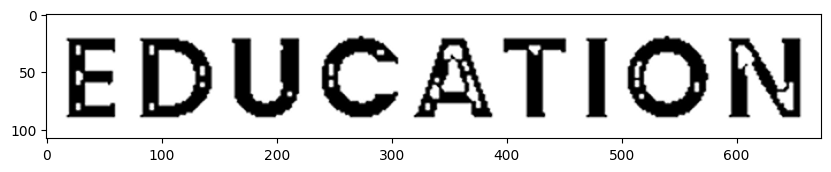

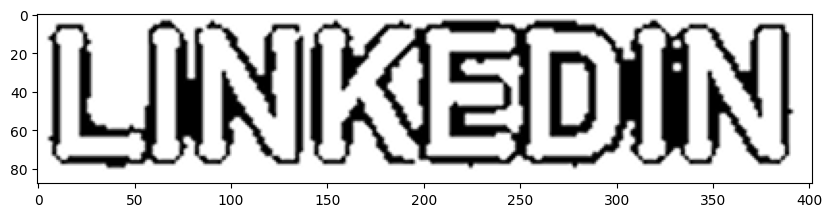

In [42]:
%%time

main()